In [1]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *

from saged import utils

In [2]:
data_dir = '../../data'

In [3]:
metadata_path = os.path.join(data_dir, 'aggregated_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)
sample_metadata = metadata['samples']

In [4]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

In [5]:
in_files = glob.glob('../../results/impute.*')
print(in_files[:5])

['../../results/impute.three_layer_impute.refinebio_labeled_dataset.4.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.1.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.3.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.2.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.0.tsv']


In [6]:
metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    
    model_info = path.strip('.tsv').split('results/impute.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
        seed = model_info[3]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
        seed = model_info[2]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    metrics = pd.concat([metrics, new_df])
    
metrics = metrics.reset_index()
metrics['trial'] = metrics.index // 10
metrics

['three_layer_impute', 'refinebio_labeled_dataset', '4']
['three_layer_impute', 'refinebio_labeled_dataset', '1']
['three_layer_impute', 'refinebio_labeled_dataset', '3']
['three_layer_impute', 'refinebio_labeled_dataset', '2']
['three_layer_impute', 'refinebio_labeled_dataset', '0']


,index,val_loss,train studies,train samples,val samples,train sample count,fraction of data used,unsupervised,supervised,trial
0,0,3.061968e+08,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",840,0.1,untransformed,three_layer_impute,0
1,1,2.990829e+08,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",1680,0.2,untransformed,three_layer_impute,0
2,2,2.941570e+08,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",2520,0.3,untransformed,three_layer_impute,0
3,3,2.936797e+08,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",3360,0.4,untransformed,three_layer_impute,0
4,4,2.958535e+08,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",4201,0.5,untransformed,three_layer_impute,0
...,...,...,...,...,...,...,...,...,...,...
245,45,7.009655e+07,"GSE58411,GSE65336,GSE42834,GSE66099,GSE65088,G...","GSM301970,GSM1108193,GSM1692256,GSM201292,GSM2...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",5170,0.6,untransformed,three_layer_impute,24
246,46,7.177166e+07,"GSE58411,GSE65336,GSE42834,GSE66099,GSE65088,G...","GSM301970,GSM1108193,GSM1692256,GSM201292,GSM2...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",6032,0.7,untransformed,three_layer_impute,24
247,47,6.780728e+07,"GSE58411,GSE65336,GSE42834,GSE66099,GSE65088,G...","GSM301970,GSM1108193,GSM1692256,GSM201292,GSM2...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",6894,0.8,untransformed,three_layer_impute,24
248,48,6.785043e+07,"GSE58411,GSE65336,GSE42834,GSE66099,GSE65088,G...","GSM301970,GSM1108193,GSM1692256,GSM201292,GSM2...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",7756,0.9,untransformed,three_layer_impute,24


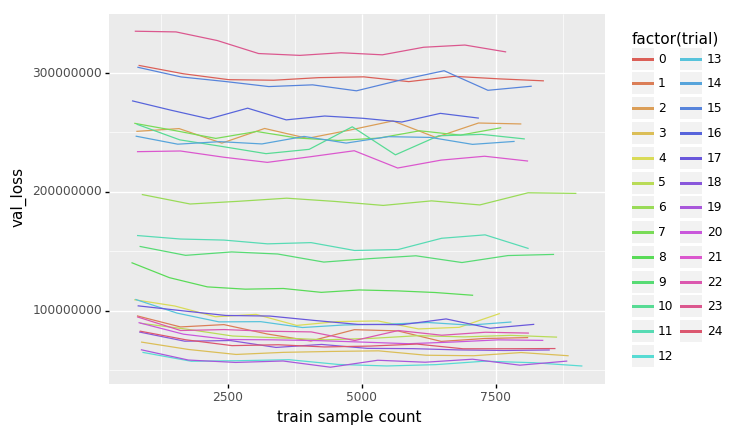

<ggplot: (8781538638093)>

In [7]:
ggplot(metrics, aes(x='train sample count', y='val_loss', color='factor(trial)')) + geom_line()

## Center trials
To make the trend easier to see, center each set of ten training iterations 

In [8]:
mean_centered_metrics = metrics.copy()
mean_centered_metrics['val_loss'] = (mean_centered_metrics['val_loss'] - 
                                     mean_centered_metrics.groupby('trial').transform('mean')['val_loss'])
mean_centered_metrics.head()

,index,val_loss,train studies,train samples,val samples,train sample count,fraction of data used,unsupervised,supervised,trial
0,0,9.900980e+06,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",840,0.1,untransformed,three_layer_impute,0
1,1,2.787128e+06,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",1680,0.2,untransformed,three_layer_impute,0
2,2,-2.138824e+06,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",2520,0.3,untransformed,three_layer_impute,0
3,3,-2.616119e+06,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",3360,0.4,untransformed,three_layer_impute,0
4,4,-4.422722e+05,"GSE26049,SRP071965,GSE31348,GSE74143,GSE38511,...","GSM1509717,GSM1692477,GSM1561972,GSM648614,SRR...","GSM1038141,GSM1038142,GSM1038143,GSM1038144,GS...",4201,0.5,untransformed,three_layer_impute,0


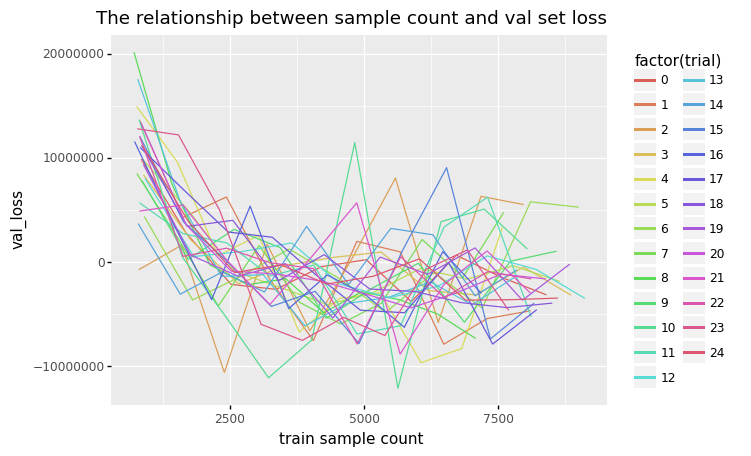

<ggplot: (8781705947447)>


In [9]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss', color='factor(trial)'))
plot += geom_line()
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

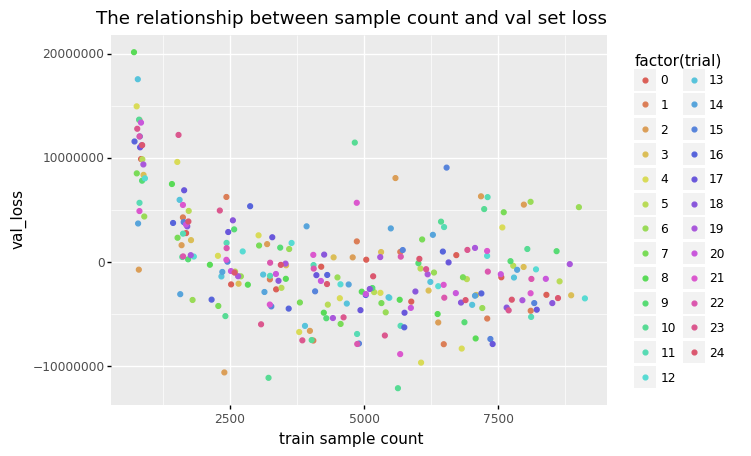

<ggplot: (8781705990331)>


In [10]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss', color='factor(trial)')) 
plot += geom_point()
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

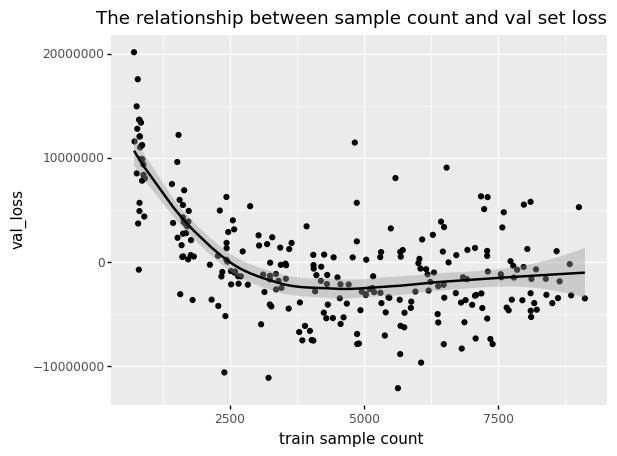

<ggplot: (8781705839186)>


In [11]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss')) 
plot += geom_point()
plot += geom_smooth(method='loess')
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)